## Mount google drive

In [1]:
from google.colab import drive
drive.mount._DEBUG = False
drive.mount('/content/gdrive/')
%ls /content/gdrive/'My Drive'/Deeplearning/Lab_ML_Projects/Ions_in_confinement/collectDatawhole.dat

Mounted at /content/gdrive/
'/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/Ions_in_confinement/collectDatawhole.dat'


## Load modules

In [2]:
#Lib imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as spliter
from sklearn import preprocessing
import joblib
import pickle
from sklearn.utils import shuffle
from collections import defaultdict
tf.__version__

'2.4.1'

## Read the dataset

In [3]:
file_path= "/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/confinement2/data/"

with open(file_path+ 'data_dump_density_preprocessed_V2.pk', 'rb') as handle:
    processed_all_data_preprocessed = pickle.load(handle)

## Preprocess the dataset and create numpy arrays from dictionary objects


In [5]:
input_data = []
output = []
errors = []
z_data = []
charge_data = []
NUM_OF_BINS = 502

#exlclude_paras = {"c": ["0.1", "0.25"]}
exlclude_paras = {"c": []}

for key, data in processed_all_data_preprocessed.items():
    #print(key, data)
    density_profiles = []
    density_errors = []
    z_data_values = []
    input_names = key.split("_")[0::2]
    input_paras = key.split("_")[1::2]
    
    ignore_this = False
    for key_p, params in exlclude_paras.items():
        if input_paras[input_names.index(key_p)] in params:
            ignore_this= True
            break
    if ignore_this:
        continue

    input_data.append(input_paras)
    density_profiles.append(data['pos'][:,1])
    density_profiles.append(data['neg'][:,1])
    output.append(density_profiles)
    density_errors.append(data['pos'][:,2])
    density_errors.append(data['neg'][:,2])
    errors.append(density_errors)
    z_data_values.append(data['pos'][:,0])
    z_data_values.append(data['neg'][:,0])
    z_data.append(z_data_values)

    #break
    
input_data = np.array(input_data)
output = np.array(output).reshape(-1,NUM_OF_BINS*2)
errors = np.array(errors).reshape(-1,NUM_OF_BINS*2)
z_data = np.array(z_data).reshape(-1,NUM_OF_BINS*2)

print("Input data shape: {}".format(input_data.shape))
print("Output data shape: {}".format(output.shape))
print("error bar data shape: {}".format(errors.shape))
print("Bin center data shape: {}".format(z_data.shape))

Input data shape: (4050, 7)
Output data shape: (4050, 1004)
error bar data shape: (4050, 1004)
Bin center data shape: (4050, 1004)


## Supporting functions

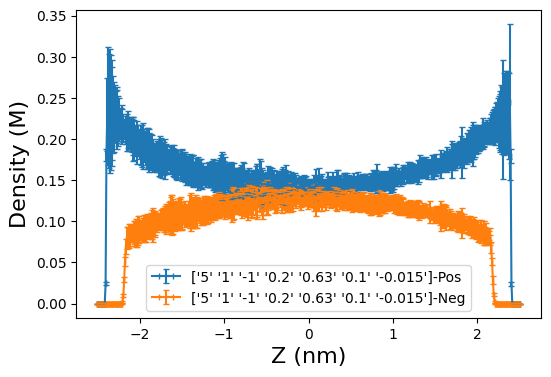

In [6]:
def plot_density_profile(z_values, density, error_bars=None, label=None):
    z_values = z_values.reshape(2,NUM_OF_BINS)
    density = density.reshape(2,NUM_OF_BINS)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    if error_bars is None:
        ax.plot(z_values[0,:], density[0,:], label=str(label) + "-Pos")
        ax.plot(z_values[1,:], density[1,:], label=str(label) + "-Neg")
    else:
        error_bars = error_bars.reshape(2,NUM_OF_BINS)
        ax.errorbar(z_values[0,:], density[0,:], xerr=0.0, yerr=error_bars[0,:], capsize=2, label=str(label) + "-Pos")
        ax.errorbar(z_values[1,:], density[1,:], xerr=0.0, yerr=error_bars[1,:], capsize=2, label=str(label) + "-Neg")
        

    ax.axis('tight')
    ax.xaxis.set_tick_params(labelsize='medium')
    ax.yaxis.set_tick_params(labelsize='medium')
    ax.set_xlabel('Z (nm)', fontsize=16)
    ax.set_ylabel('Density (M)', fontsize=16)
    ax.legend()

selected_index = np.random.randint(z_data.shape[0], size=1)[0]

plot_density_profile(z_data[selected_index], output[selected_index], errors[selected_index], label=input_data[selected_index])

## Select data for model training

In [7]:
train_test_split = 0.85

print("Input data shape: {}".format(input_data.shape))
print("Output data shape: {}".format(output.shape))

input_data_suff, output_suff,  errors_suff, z_data_shuff = shuffle(input_data, output, errors, z_data)

train_test_split_ = int(input_data_suff.shape[0]*train_test_split)

x_train = input_data_suff[0:train_test_split_]#.astype("float64")
x_test = input_data_suff[train_test_split_:]#.astype("float64")
y_train = output_suff[0:train_test_split_]#.astype("float64")
y_test = output_suff[train_test_split_:]#.astype("float64")

error_train = errors_suff[0:train_test_split_]#.astype("float64")
error_test = errors_suff[train_test_split_:]#.astype("float64")
z_data_train = z_data_shuff[0:train_test_split_]#.astype("float64")
z_data_test = z_data_shuff[train_test_split_:]#.astype("float64")
#x_train, x_test, y_train, y_test = spliter.train_test_split(input_data, output, test_size=(1-train_test_split), random_state=100)

print("Train input: ", x_train.shape)
print("Train Output", y_train.shape)
print("Test input: ", x_test.shape)
print("Test Output", y_test.shape)

Input data shape: (4050, 7)
Output data shape: (4050, 1004)
Train input:  (3442, 7)
Train Output (3442, 1004)
Test input:  (608, 7)
Test Output (608, 1004)


## Input feature scaling

In [8]:
#scaler = preprocessing.MinMaxScaler() # s the probably the most famous scaling algorithm, and follows the following formula for each feature:
#scaler = preprocessing.StandardScaler() # assumes your data is normally distributed within each feature
#scaler = preprocessing.RobustScaler() # interquartile range, so if there are outliers in the data, you might want to consider the Robust Scaler
#scaler = preprocessing.Normalizer() # The normalizer scales each value by dividing each value by its magnitude in n-dimensional space for n number of features.
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled_x_train = scaler.fit_transform(x_train)
#arr_transformed = sc.fit_transform(arr_selected)
scaled_x_test = scaler.transform(x_test)
# Save the scaler for future use
joblib.dump(scaler, file_path+'scaler_new_custom_errorV2.pkl')

['/content/gdrive/My Drive/Deeplearning/Lab_ML_Projects/confinement2/data/scaler_new_custom_errorV2.pkl']

## Model parameters

In [9]:
# hyper parameters
learningRate = 0.0001
beta_1 = 0.9
beta_2 = 0.999
decay = 0.000000

batchSize = 32
dropout_rate=0.10
epochs= 20000

# Network Parameters
inputFeatures = 7 
hiddenUnits1 = 256 # 1st layer number of neurons
hiddenUnits2 = 512 # 2nd layer number of neurons
#hiddenUnits3 = 512 # 3rd layer number of neurons
outputClasses = NUM_OF_BINS*2

## ANN Model

### Custom loss

In [10]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [11]:
#tf.reduce_mean(tf.square(y_actual - y_pred))

#@tf.function
def CustomLossWithErrorBars(errorBars):
    #@tf.function
    def loss(y_actual, y_pred):
        #print('Actual ',y_actual.shape)
        #print('Pred   ',y_pred.shape)
        #print('errorBars   ',errorBars.shape)
        squared_difference_upper = 0.5*tf.square(y_actual + errorBars/2.0 - y_pred)
        squared_difference_lower = 0.5*tf.square(y_actual - errorBars/2.0 - y_pred)
        mean_loss = tf.reduce_mean(squared_difference_upper + squared_difference_lower, axis=-1)  # Note the `axis=-1, last axis`
        #print('mean_loss   ',mean_loss.shape)
        return mean_loss
    return loss


In [12]:
#This is He initializer
initializer = tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal', seed=None)

physical_p_input = tf.keras.Input(shape=(inputFeatures,))
errorbar_input = tf.keras.Input(shape=(outputClasses,))

#, kernel_initializer=initializer

dense1 =  tf.keras.layers.Dense(hiddenUnits1, activation="relu", kernel_initializer=initializer)(physical_p_input)
drop1 = tf.keras.layers.Dropout(rate=dropout_rate)(dense1)
dense2 =  tf.keras.layers.Dense(hiddenUnits2, activation="sigmoid", kernel_initializer=initializer)(drop1)
drop2 = tf.keras.layers.Dropout(rate=dropout_rate)(dense2)
#dense3 = tf.keras.layers.Dense(outputClasses, activation="sigmoid", kernel_initializer=initializer)(drop2)
#drop3 = tf.keras.layers.Dropout(rate=dropout_rate)(dense3)
density_output = tf.keras.layers.Dense(outputClasses, activation="relu", kernel_initializer=initializer)(drop2)

model = tf.keras.Model(inputs=[physical_p_input, errorbar_input], outputs=[density_output], name="ions_surrogate_model2")

#loss=CustomLossWithErrorBars(errorBars=errorbar_input)
#loss=tf.keras.losses.mean_squared_error
model.compile(loss=CustomLossWithErrorBars(errorBars=errorbar_input), optimizer=tf.keras.optimizers.Adam(lr=learningRate, beta_1=beta_1,beta_2=beta_2, decay=decay), experimental_run_tf_function=False)

## Training

In [ ]:
history = model.fit(x=[scaled_x_train, error_train], y=y_train, epochs=epochs, batch_size = batchSize, verbose = 1,  shuffle=True, validation_data = ([scaled_x_test, error_test], y_test))

Train on 3442 samples, validate on 608 samples
Epoch 1/20000
3442/3442 [==============================] - 8s 2ms/sample - loss: 0.8043 - val_loss: 0.5553
Epoch 2/20000
1056/3442 [========>.....................] - ETA: 0s - loss: 0.5596

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Streaming output truncated to the last 5000 lines.
Epoch 17501/20000
3442/3442 [==============================] - 1s 152us/sample - loss: 0.0014 - val_loss: 5.6597e-04
Epoch 17502/20000
3442/3442 [==============================] - 1s 161us/sample - loss: 0.0014 - val_loss: 5.5223e-04
Epoch 17503/20000
3442/3442 [==============================] - 1s 157us/sample - loss: 0.0014 - val_loss: 6.1376e-04
Epoch 17504/20000
3442/3442 [==============================] - 1s 163us/sample - loss: 0.0014 - val_loss: 5.7932e-04
Epoch 17505/20000
3442/3442 [==============================] - 1s 174us/sample - loss: 0.0015 - val_loss: 5.9379e-04
Epoch 17506/20000
3442/3442 [==============================] - 1s 155us/sample - loss: 0.0014 - val_loss: 5.8901e-04
Epoch 17507/20000
3442/3442 [==============================] - 1s 170us/sample - loss: 0.0014 - val_loss: 6.2357e-04
Epoch 17508/20000
3442/3442 [==============================] - 1s 167us/sample - loss: 0.0014 - val_loss: 5.6454e-04
Epoch 17509/2

## Final loss values with tradional loss function
* learningRate = 0.0005, batchSize = 32, hiddenUnits1 = 512, hiddenUnits2 = 512, dropout_rate=0.15: : 95.1% accuracy
* learningRate = 0.0005, batchSize = 32, hiddenUnits1 = 256, hiddenUnits2 = 512, dropout_rate=0.15: loss: 0.0016 - val_loss: 0.0012: 95.1% accuracy
* learningRate = 0.0005, batchSize = 32, hiddenUnits1 = 128, hiddenUnits2 = 512, dropout_rate=0.15: loss: 0.0021 - val_loss: 0.0019       : 85.1% accuracy





## Training and testing error

dict_keys(['loss', 'val_loss'])


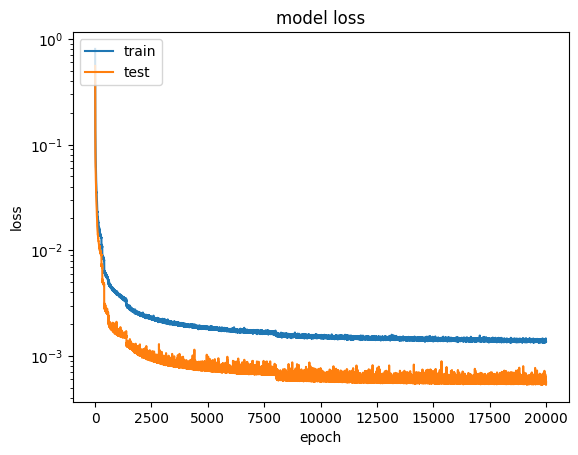

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['loss', 'val_loss'])


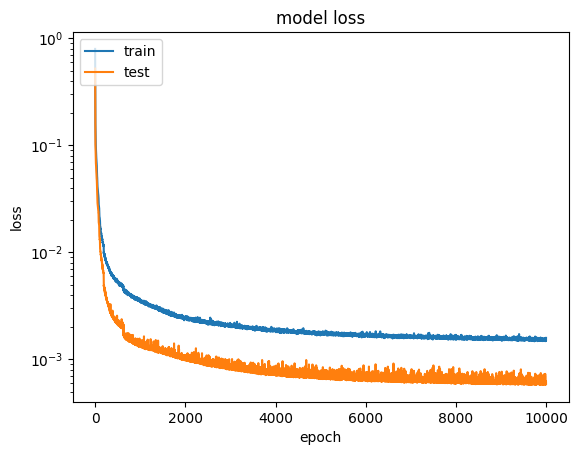

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model details and save the model

In [ ]:
model.summary()
model.save(file_path+ 'my_model_custom_error_v2_6.h5')

Model: "ions_surrogate_model2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          2048        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          131584      dropout[0][0]                    
______________________________________________________________________________

## Load the models and predict

In [14]:
scaler = joblib.load(file_path+'scaler_new_custom_errorV2.pkl')
#scaler = joblib.load(file_path+'scaler_new.pkl')
new_model = tf.keras.models.load_model(file_path+'my_model_custom_error_v2_5.h5', compile=False) 
#new_model = tf.keras.models.load_model(file_path+'my_model_custom_error6.h5', compile=False)  # this is 96 % accuracy model
#new_model = tf.keras.models.load_model(file_path+'my_model_custom_error4.h5', compile=False)  # this is 94 % accuracy model
#new_model = tf.keras.models.load_model(file_path+ 'my_model_new.h5')
new_model.summary()

Model: "ions_surrogate_model2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          2048        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          131584      dropout[0][0]                    
______________________________________________________________________________

# Evaluating testing accuracy within error bars

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.9654719936045292


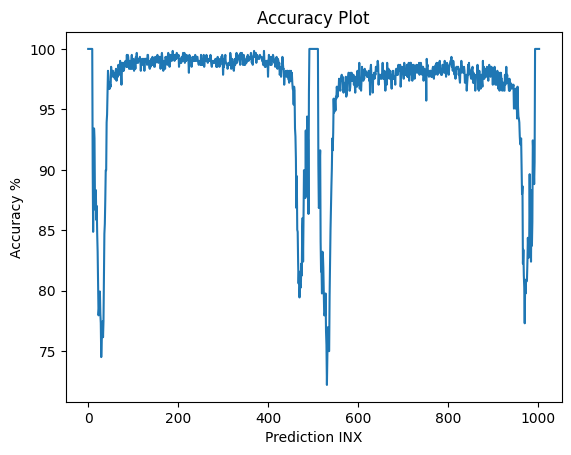

In [15]:
def evaluate_one_simulation(prediction, truth , errorbar):
    cnt = 0;
    for j in range(prediction.shape[0]):
      if (abs(prediction[j] - truth[j]) <= errorbar[j]):
        cnt = cnt+1
    return cnt/prediction.shape[0]

def evaluate(prediction, truth , errorbar):
  accuracy = []
  for i in range(prediction.shape[1]):
    cnt = 0;
    for j in range(prediction.shape[0]):
      if (abs(prediction[j,i] - truth[j,i]) <= errorbar[j,i]):
        cnt = cnt+1;
    accuracy.append(cnt/prediction.shape[0]);
  
  return np.array(accuracy)


predictions = new_model.predict([scaler.transform(x_test), error_test])
acc = evaluate(predictions, y_test, error_test)
print(np.mean(acc))
plt.plot(acc*100.0)
plt.title('Accuracy Plot')
plt.ylabel('Accuracy %')
plt.xlabel('Prediction INX')
plt.show()


# Examples of prediction graphs for test data

['4.4' '1' '-1' '0.5225' '0.415' '1.0' '-0.01']

0.9790836653386454


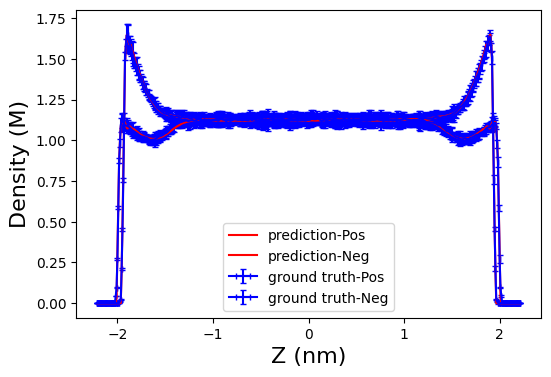

In [10]:
def plot_density_profile(ax, z_values, density, error_bars=None, label=None, title=None, color='b'):
    z_values = z_values.reshape(2,NUM_OF_BINS)
    density = density.reshape(2,NUM_OF_BINS)
    
    if error_bars is None:
        ax.plot(z_values[0,:], density[0,:], label=str(label) + "-Pos", color=color)
        ax.plot(z_values[1,:], density[1,:], label=str(label) + "-Neg", color=color)
    else:
        error_bars = error_bars.reshape(2,NUM_OF_BINS)
        ax.errorbar(z_values[0,:], density[0,:], xerr=0.0, yerr=error_bars[0,:], capsize=2, label=str(label) + "-Pos", color=color)
        ax.errorbar(z_values[1,:], density[1,:], xerr=0.0, yerr=error_bars[1,:], capsize=2, label=str(label) + "-Neg", color=color)
    
    print(title)
    ax.set_title(title)

    ax.axis('tight')
    ax.xaxis.set_tick_params(labelsize='medium')
    ax.yaxis.set_tick_params(labelsize='medium')
    ax.set_xlabel('Z (nm)', fontsize=16)
    ax.set_ylabel('Density (M)', fontsize=16)
    #ax.legend()


selected_index = np.random.randint(x_test.shape[0], size=1)[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

plot_density_profile(ax, z_data_test[selected_index], y_test[selected_index], error_test[selected_index], label="ground truth", title=str(x_test[selected_index]), color='b')

plot_density_profile(ax, z_data_test[selected_index], predictions[selected_index], error_bars=None, label="prediction", title="", color='r')

ax.legend()

print(evaluate_one_simulation(predictions[selected_index], y_test[selected_index] , error_test[selected_index]))
#x_inverse = scaler.inverse_transform(X_test)

In [ ]:
print(predictions[selected_index][0:200])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.10178638 0.21132535 0.43832463
 0.6292192  0.81408644 0.9548944  1.0465411  1.0999545  1.1142757
 1.1085522  1.0856792  1.073095   1.0547795  1.037647   1.0216682
 1.0060071  0.99198216 0.9771626  0.9616195  0.9494873  0.9360828
 0.9229303  0.91069376 0.8980976  0.88620794 0.8742998  0.86364806
 0.85377985 0.8429041  0.8333877  0.8237356  0.8142858  0.80439395
 0.7959411  0.7872256  0.7786787  0.7716299  0.76428753 0.7565549
 0.748994   0.7414791  0.7349808  0.7294649  0.7231259  0.7171351
 0.7122309  0.7074765  0.70225376 0.6979525  0.6943648  0.69049436
 0.68599313 0.68191344 0.6788391  0.67600715 0.67365265 0.6713955
 0.66946703 0.6666901  0.66509086 0.66269

# Evaluating Train accuracy within error bars

0.964336726308016


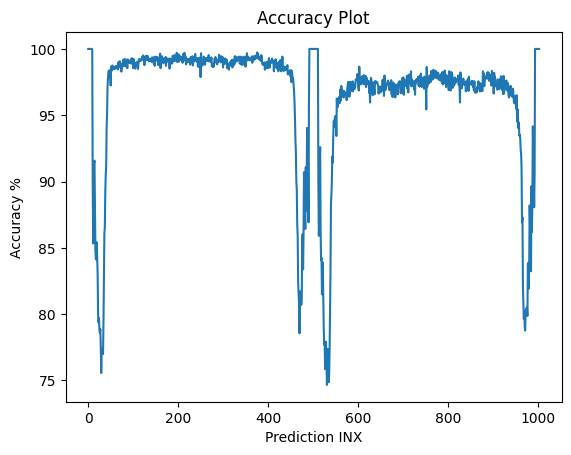

In [16]:
predictions_train = new_model.predict([scaler.transform(x_train), error_train])
acc = evaluate(predictions_train, y_train, error_train)
print(np.mean(acc))
plt.plot(acc*100.0)
plt.title('Accuracy Plot')
plt.ylabel('Accuracy %')
plt.xlabel('Prediction INX')
plt.show()

# Examples of prediction graphs for train data

['4.2' '1' '-1' '0.2' '0.63' '0.5' '-0.015']

0.9830677290836654


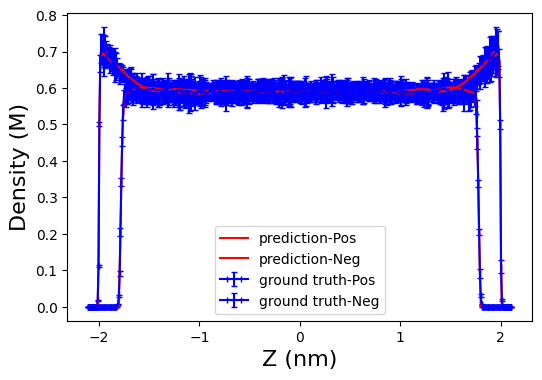

In [12]:
def plot_density_profile(ax, z_values, density, error_bars=None, label=None, title=None, color='b'):
    z_values = z_values.reshape(2,NUM_OF_BINS)
    density = density.reshape(2,NUM_OF_BINS)
    
    if error_bars is None:
        ax.plot(z_values[0,:], density[0,:], label=str(label) + "-Pos", color=color)
        ax.plot(z_values[1,:], density[1,:], label=str(label) + "-Neg", color=color)
    else:
        error_bars = error_bars.reshape(2,NUM_OF_BINS)
        ax.errorbar(z_values[0,:], density[0,:], xerr=0.0, yerr=error_bars[0,:], capsize=2, label=str(label) + "-Pos", color=color)
        ax.errorbar(z_values[1,:], density[1,:], xerr=0.0, yerr=error_bars[1,:], capsize=2, label=str(label) + "-Neg", color=color)
    
    print(title)
    ax.set_title(title)

    ax.axis('tight')
    ax.xaxis.set_tick_params(labelsize='medium')
    ax.yaxis.set_tick_params(labelsize='medium')
    ax.set_xlabel('Z (nm)', fontsize=16)
    ax.set_ylabel('Density (M)', fontsize=16)
    #ax.legend()


selected_index = np.random.randint(x_train.shape[0], size=1)[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

plot_density_profile(ax, z_data_train[selected_index], y_train[selected_index], error_train[selected_index], label="ground truth", title=str(x_train[selected_index]), color='b')

plot_density_profile(ax, z_data_train[selected_index], predictions_train[selected_index], error_bars=None, label="prediction", title="", color='r')

ax.legend()

print(evaluate_one_simulation(predictions_train[selected_index], y_train[selected_index] , error_train[selected_index]))
#x_inverse = scaler.inverse_transform(X_test)

## Integrated Charge Testing samples

['4.4' '1' '-1' '0.5225' '0.5225' '0.1' '-0.015']


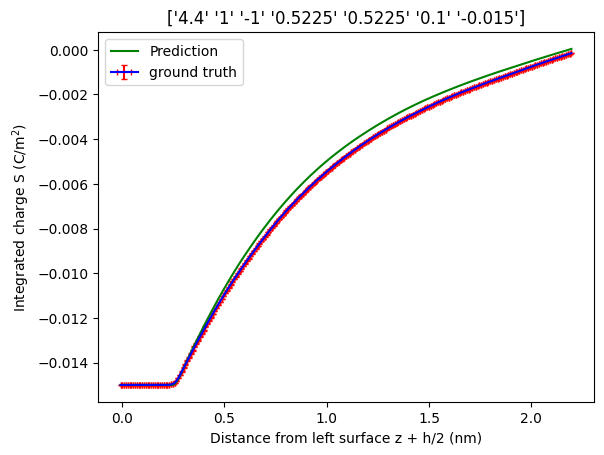

In [18]:
def get_integrated_charge(density_pos, density_neg, clen_value, charge_on_wall_value):

  bin_width_nm =  abs(density_pos[0,0] - density_pos[1,0])
  xx = density_pos[:,0] + clen_value/2
  # integrated charge
  yy_temp = (density_pos[:,1] - density_neg[:,1])*bin_width_nm*0.096
  yy = []
  charge_sum = charge_on_wall_value
  for yy_temp_val in yy_temp:
      charge_sum += yy_temp_val
      yy.append(charge_sum)  
  yy = np.array(yy)

  #Take half of the integrated charge profile
  xx_half = xx[0:xx.shape[0]//2:1]
  yy_half = yy[0:xx.shape[0]//2:1]
  
  if density_pos.shape[1] == 3:
    yyrr = np.sqrt(density_pos[:,2]**2 + density_neg[:,2]**2)*bin_width_nm*0.096
    yyrr_half = yyrr[0:xx.shape[0]//2:1]
    integrated_charge = np.column_stack((xx_half,yy_half,yyrr_half))
  else:
    integrated_charge = np.column_stack((xx_half,yy_half))

  return integrated_charge

selected_index = np.random.randint(x_test.shape[0], size=1)[0]

label_ = x_test[selected_index]
#label_ = 'Z_4.2_p_1_n_-1_d_0.63_a_0.3075_c_1.0_i_-0.02'
#label_ = "Z_5_p_1_n_-1_d_0.2_a_0.63_c_2.0_i_-0.01"
print(label_)

z_values = z_data_test[selected_index].reshape(2,NUM_OF_BINS)
density = y_test[selected_index].reshape(2,NUM_OF_BINS)
errors_ = error_test[selected_index].reshape(2,NUM_OF_BINS)
density_pos = np.column_stack((z_values[0,:],density[0,:],errors_[0,:]))
density_neg = np.column_stack((z_values[1,:],density[1,:],errors_[1,:]))

clen_value = float(label_[0])
charge_on_wall_value = float(label_[-1])
#charge_on_wall_value = processed_all_data_preprocessed[label_]['surf_charge']

integrated_charge = get_integrated_charge(density_pos, density_neg, clen_value, charge_on_wall_value)

plt.figure('Distribution of integrated charge')
plt.title(str(label_))
plt.xlabel('Distance from left surface z + h/2 (nm)', fontsize=10)
plt.ylabel('Integrated charge S (C/m$^2$)', fontsize=10)

plt.errorbar(integrated_charge[:,0],integrated_charge[:,1],xerr=0.0, yerr=integrated_charge[:,2], c='b', ecolor='r', capsize=2, label="ground truth")

#------------------------------------------------------------

z_values = z_data_test[selected_index].reshape(2,NUM_OF_BINS)
density = predictions[selected_index].reshape(2,NUM_OF_BINS)
errors_ = error_test[selected_index].reshape(2,NUM_OF_BINS)
density_pos = np.column_stack((z_values[0,:],density[0,:],errors_[0,:]))
density_neg = np.column_stack((z_values[1,:],density[1,:],errors_[1,:]))

integrated_charge = get_integrated_charge(density_pos, density_neg, clen_value, charge_on_wall_value)

plt.plot(integrated_charge[:,0],integrated_charge[:,1], c='green', label="Prediction")

#print(np.column_stack((xx_half,yy_half)))
plt.legend()

## Integrated Charge Training samples

['5' '1' '-1' '0.5225' '0.2' '0.1' '-0.015']


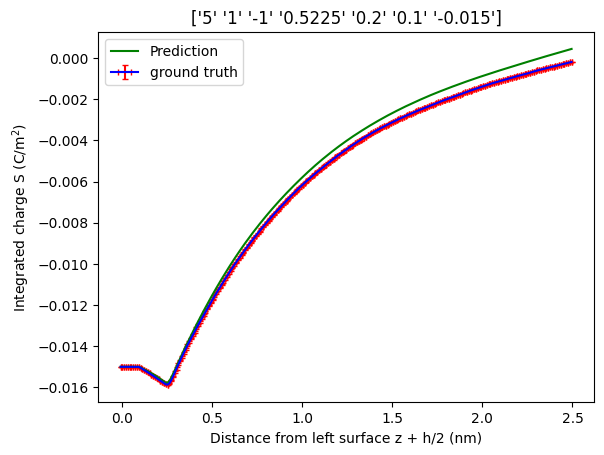

In [ ]:
selected_index = np.random.randint(x_train.shape[0], size=1)[0]

label_ = x_train[selected_index]
#label_ = 'Z_4.2_p_1_n_-1_d_0.63_a_0.3075_c_1.0_i_-0.02'
#label_ = "Z_5_p_1_n_-1_d_0.2_a_0.63_c_2.0_i_-0.01"
print(label_)

z_values = z_data_train[selected_index].reshape(2,NUM_OF_BINS)
density = y_train[selected_index].reshape(2,NUM_OF_BINS)
errors_ = error_train[selected_index].reshape(2,NUM_OF_BINS)
density_pos = np.column_stack((z_values[0,:],density[0,:],errors_[0,:]))
density_neg = np.column_stack((z_values[1,:],density[1,:],errors_[1,:]))

clen_value = float(label_[0])
charge_on_wall_value = float(label_[-1])
#charge_on_wall_value = processed_all_data_preprocessed[label_]['surf_charge']

integrated_charge = get_integrated_charge(density_pos, density_neg, clen_value, charge_on_wall_value)

plt.figure('Distribution of integrated charge')
plt.title(str(label_))
plt.xlabel('Distance from left surface z + h/2 (nm)', fontsize=10)
plt.ylabel('Integrated charge S (C/m$^2$)', fontsize=10)

plt.errorbar(integrated_charge[:,0],integrated_charge[:,1],xerr=0.0, yerr=integrated_charge[:,2], c='b', ecolor='r', capsize=2, label="ground truth")

#------------------------------------------------------------

z_values = z_data_train[selected_index].reshape(2,NUM_OF_BINS)
density = predictions_train[selected_index].reshape(2,NUM_OF_BINS)
errors_ = error_train[selected_index].reshape(2,NUM_OF_BINS)
density_pos = np.column_stack((z_values[0,:],density[0,:],errors_[0,:]))
density_neg = np.column_stack((z_values[1,:],density[1,:],errors_[1,:]))

integrated_charge = get_integrated_charge(density_pos, density_neg, clen_value, charge_on_wall_value)

plt.plot(integrated_charge[:,0],integrated_charge[:,1], c='green', label="Prediction")

#print(np.column_stack((xx_half,yy_half)))
plt.legend()

## Predict everything from the input parameters

In [430]:
'''
def get_bin_values_for_input(salt_value, pion_value, nion_value, clen_value, ion_diam_value_pos, ion_diam_value_neg, charge_on_wall_value):
  bin_width = 0.05
  unit_len = min(ion_diam_value_pos, ion_diam_value_neg)
  lz = clen_value/unit_len
  number_of_bins = int(lz // bin_width)# floor
  #bin_width = lz / number_of_bins

  most_right_bin = bin_width/2.0
  while (most_right_bin + bin_width/2.0) <= (lz/2+0.00001):
      most_right_bin = np.round(most_right_bin + bin_width, 6)

  most_left_bin = -most_right_bin
  start =most_left_bin#-2.505
  stop = most_right_bin#2.505
  z_values = np.linspace(start, stop, num=502, endpoint=True)
  z_values = np.append(z_values,z_values)*unit_len
  return z_values

selected_index=np.random.randint(x_train.shape[0], size=1)[0]#1478##2#10#52#2914

print(selected_index, x_train[selected_index])


salt_value = 0.1
pion_value = 1
nion_value = -1
clen_value = 4.4
ion_diam_value_pos = 0.63
ion_diam_value_neg = 0.5225
charge_on_wall_value = -0.015

salt_value = float(x_train[selected_index][5])
pion_value = float(x_train[selected_index][1])
nion_value = float(x_train[selected_index][2])
clen_value = float(x_train[selected_index][0])
ion_diam_value_pos = float(x_train[selected_index][3])
ion_diam_value_neg = float(x_train[selected_index][4])
charge_on_wall_value = float(x_train[selected_index][6])

z_values = get_bin_values_for_input(salt_value, pion_value, nion_value, clen_value, ion_diam_value_pos, ion_diam_value_neg, charge_on_wall_value)

print(z_values)
np.sum(abs(z_data_train[selected_index] - z_values))

'''


1442 ['4.2' '1' '-1' '0.2' '0.415' '0.75' '-0.01']
[-2.105      -2.09659681 -2.08819361 ...  2.08819361  2.09659681
  2.105     ]


1.4930418013037183e-13

[[ 2.      1.     -1.      4.4     0.63    0.5225 -0.02  ]]


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


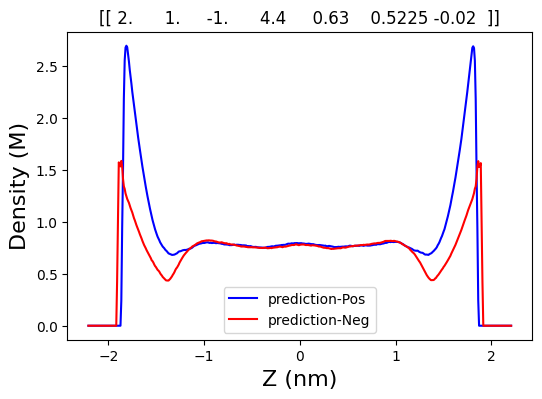

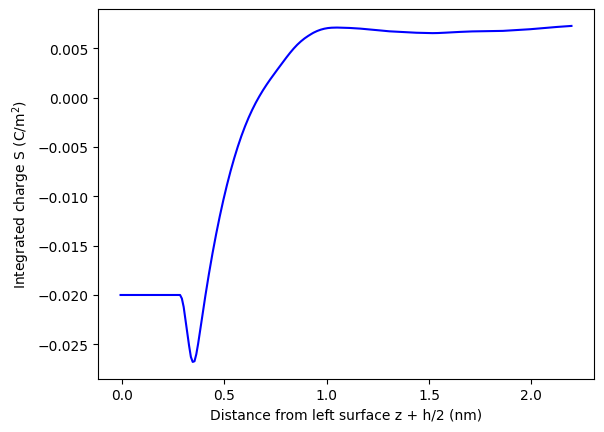

In [450]:
def get_bin_values_for_input(salt_value, pion_value, nion_value, clen_value, ion_diam_value_pos, ion_diam_value_neg, charge_on_wall_value):
  bin_width = 0.05
  unit_len = min(ion_diam_value_pos, ion_diam_value_neg)
  lz = clen_value/unit_len
  number_of_bins = int(lz // bin_width)# floor
  #bin_width = lz / number_of_bins

  most_right_bin = bin_width/2.0
  while (most_right_bin + bin_width/2.0) <= (lz/2+0.00001):
      most_right_bin = np.round(most_right_bin + bin_width, 6)

  most_left_bin = -most_right_bin
  start =most_left_bin#-2.505
  stop = most_right_bin#2.505
  z_values = np.linspace(start, stop, num=502, endpoint=True)
  z_values = np.append(z_values,z_values)*unit_len
  return z_values


def plot_density_profile(ax, z_values, density, label=None, title=None):
    z_values = z_values.reshape(2,NUM_OF_BINS)
    density = density.reshape(2,NUM_OF_BINS)
    
    
    ax.plot(z_values[0,:], density[0,:], label=str(label) + "-Pos", color='b')
    ax.plot(z_values[1,:], density[1,:], label=str(label) + "-Neg", color='r')
    
    
    print(title)
    ax.set_title(title)

    ax.axis('tight')
    ax.xaxis.set_tick_params(labelsize='medium')
    ax.yaxis.set_tick_params(labelsize='medium')
    ax.set_xlabel('Z (nm)', fontsize=16)
    ax.set_ylabel('Density (M)', fontsize=16)
    #ax.legend()


def get_integrated_charge(density_pos, density_neg, clen_value, charge_on_wall_value):

  bin_width_nm =  abs(density_pos[0,0] - density_pos[1,0])
  xx = density_pos[:,0] + clen_value/2
  # integrated charge
  yy_temp = (density_pos[:,1] - density_neg[:,1])*bin_width_nm*0.096
  yy = []
  charge_sum = charge_on_wall_value
  for yy_temp_val in yy_temp:
      charge_sum += yy_temp_val
      yy.append(charge_sum)  
  yy = np.array(yy)

  #Take half of the integrated charge profile
  xx_half = xx[0:xx.shape[0]//2:1]
  yy_half = yy[0:xx.shape[0]//2:1]
  
  if density_pos.shape[1] == 3:
    yyrr = np.sqrt(density_pos[:,2]**2 + density_neg[:,2]**2)*bin_width_nm*0.096
    yyrr_half = yyrr[0:xx.shape[0]//2:1]
    integrated_charge = np.column_stack((xx_half,yy_half,yyrr_half))
  else:
    integrated_charge = np.column_stack((xx_half,yy_half))

  return integrated_charge

###############--------------------------------------------------
salt_value = 2.0
pion_value = 1
nion_value = -1
clen_value = 4.4
ion_diam_value_pos = 0.63
ion_diam_value_neg = 0.5225
charge_on_wall_value = -0.02

z_values = get_bin_values_for_input(salt_value, pion_value, nion_value, clen_value, ion_diam_value_pos, ion_diam_value_neg, charge_on_wall_value)
input_parms = np.array([salt_value, pion_value, nion_value, clen_value, ion_diam_value_pos, ion_diam_value_neg, charge_on_wall_value]).reshape(1, -1)
error_train = np.zeros(shape = z_values.shape).reshape(1, -1)
predictions_new = new_model.predict([scaler.transform(input_parms), error_train])


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

plot_density_profile(ax, z_values, predictions_new, label="prediction", title=input_parms)

ax.legend()

############-----------------------------------------
#charge_on_wall_value = processed_all_data_preprocessed[label_]['surf_charge']
z_values_ = z_values.reshape(2,NUM_OF_BINS)
density = predictions_new.reshape(2,NUM_OF_BINS)

density_pos = np.column_stack((z_values_[0,:],density[0,:]))
density_neg = np.column_stack((z_values_[1,:],density[1,:]))

integrated_charge = get_integrated_charge(density_pos, density_neg, clen_value, charge_on_wall_value)

plt.figure('Distribution of integrated charge')
plt.xlabel('Distance from left surface z + h/2 (nm)', fontsize=10)
plt.ylabel('Integrated charge S (C/m$^2$)', fontsize=10)

plt.plot(integrated_charge[:,0],integrated_charge[:,1], c='b', label="ground truth")

